# VGG16_pretrain_test.ipynb

Experience the pre-trained VGG-16 network.
This network is trained with 1000 class, 1.2M images on ImageNet.

### This code requires pytorch and torchvision.
### specify your image want to recognize at the last block.

## Enjoy computer vision!

In [1]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [2]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.2.0
Torchvision Version:  0.4.0


In [4]:
# Load pre-trained VGG-16 network
# The first time you run it, it will take some time to download the file

# Build a VGG-16 model instance
use_pretrained = True  # use pre-trained weights
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # set evaluation (not train) mode

# display network architecture
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# Pre-processing class
class BaseTransform():
    """
    resize and perform a color normalization 
           for the input image

    Attributes
    ----------
    resize : int
        resized image size
    mean : (R, G, B)
        mean of R,G,B
    std : (R, G, B)
        std of R,G,B
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # length of minor axis =resize
            transforms.CenterCrop(resize),  # center crop with resize x resize
            transforms.ToTensor(),  # convert into Torch tensor
            transforms.Normalize(mean, std)  # normalize color
        ])

    def __call__(self, img):
        return self.base_transform(img)

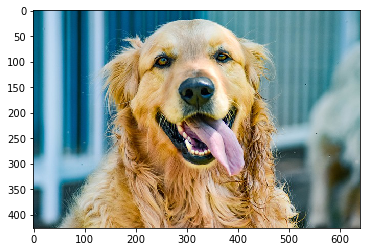

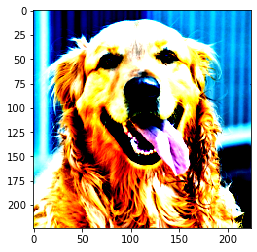

In [8]:
 # Confirm color normalization

# 1. Load image
image_file_path = './goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [Height][Width][Color=RGB]

# 2. Display original image
plt.imshow(img)
plt.show()

# 3. display original and processed image
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# Convert (C,H,W) to (H,W,C), normalize it into [0,1], and display
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [9]:

ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [14]:
# Post-processing class to predict labels from network output
class ILSVRCPredictor():
    """
    obtain ILSVRC data label from output

    Attributes
    ----------
    class_index (int) : label_name (str)
            dictionary-type variables
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        obtain ILSVRC label with highest prob from "out". 

        Parameters
        ----------
        out : torch.Size([1, 1000])
            output from network

        Returns
        -------
        predicted_label_name : str
            most plausible class name
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name
    
    def predict_top5(self, out):
        """
        obtain ILSVRC label and prob. with highest prob from "out". 

        Parameters
        ----------
        out : torch.Size([1, 1000])
            output from network

        Returns
        -------
        predicted_label_name : str
            most plausible class name
        """
        out_scores=out.detach().numpy()[0]
        total=np.sum(np.exp(out_scores))
        p_score=np.exp(out_scores)/total*100
        top5id=np.argsort(-out_scores)[0:5]
        top5key=[str(n) for n in top5id]
        print('\n results                    [%]')
        print('---------------------------------')
        for key in top5key:
            obj=self.class_index[key][1]
            p=p_score[int(key)]
            print('{:<20}'.format(obj), '{:>.2f}'.format(p))
        
        top5p=p_score[top5id]
        #print("top5id= ", top5id)
        #print("top5p= ",top5p)
        return top5id, top5p    

## You can define arbitrary image file willing to recognize
###  as 'Image_file_path'.

In [15]:
# Creates an instance of ILSVRCPredictor
predictor = ILSVRCPredictor(ILSVRC_class_index)

# Load input image
image_file_path = './goldenretriever-3724972_640.jpg' ## You can change target image
img = Image.open(image_file_path)  # [Height][Width][Color=RGB]

# After base-transform (color normalization etc), add one dimension for mini-batch
transform = BaseTransform(resize, mean, std)  # create instance of base-transform 
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])

# input image to the VGG-16 model and obtain outputs (softmaxed 1000dim) 
out = net(inputs)  # torch.Size([1, 1000])
#predictor.predict_top5_show(out)
top5id, top5p=predictor.predict_top5(out)



 results                    [%]
---------------------------------
golden_retriever     97.61
cocker_spaniel       0.83
tennis_ball          0.37
Irish_setter         0.17
kuvasz               0.14
